# **Imports**

In [406]:
import numpy as np
import torch
import torch.autograd.functional as AD
from torch import nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR
from torchdiffeq import odeint
from scipy.integrate import odeint as odeint_scipy
from functools import partial
import functorch
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque
from matplotlib import animation
import tensorflow as tf
import os
import shutil

In [229]:
def dynamic_fn(np_fn, torch_fn, x, is_np=False):
    if type(x) is np.ndarray or is_np:
        return np_fn(x)
    return torch_fn(x)

def cos(x):
    return dynamic_fn(np.cos, torch.cos, x)

def sin(x):
    return dynamic_fn(np.sin, np.cos, x)

def normalize_dp(state):
    # wrap generalized coordinates to [-pi, pi]
    return dynamic_fn(np.concatenate, torch.cat, [(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]], is_np=type(state) is np.ndarray)

In [297]:
def plot_trajectory(*trajectories, save=True, m1=1, m2=1, l1=1, l2=1):
    L = l1 + l2
    history_len = trajectories[0].shape[0]
    dt = 1e-1
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(autoscale_on=False, xlim=(-L, L), ylim=(-L, 1.))
    ax.set_aspect('equal')
    ax.grid()
    line = [ax.plot([], [], 'o-', lw=2, color=['blue', 'red', 'black'][i])[0] for i, _ in enumerate(trajectories)]
    trace = [ax.plot([], [], '.-', lw=1, ms=2, color=['orange', 'green', 'lavender'][i])[0] for i, _ in enumerate(trajectories)]
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    history_x, history_y = [deque(maxlen=history_len) for _ in trajectories], [deque(maxlen=history_len) for _ in trajectories]

    def animate(i):
        for j in range(len(trajectories)):
            animate_trajectory(j, i)
        return *line, *trace, time_text

    def animate_trajectory(j, i):
        theta1, theta2, _, _ = trajectories[j][i]
        theta1, theta2 = theta1.detach().numpy(), theta2.detach().numpy()
        x1, y1 = l1 * np.cos(theta1), -l1 * np.sin(theta1)
        x2, y2 = l2 * np.cos(theta2) + x1, -l2 * np.sin(theta2) + y1

        thisy = [0, -x1, -x2]
        thisx = [0, y1, y2]

        if i == 0:
            history_x[j].clear()
            history_y[j].clear()

        history_x[j].appendleft(thisx[2])
        history_y[j].appendleft(thisy[2])

        line[j].set_data(thisx, thisy)
        trace[j].set_data(history_x[j], history_y[j])
        time_text.set_text(time_template % (i*dt))

    anim = animation.FuncAnimation(fig, animate, trajectories[0].shape[0], interval=dt*600, blit=True)
    return anim

## **Model the Double Pendulum**
Following [Diego Assencio's derivation](https://diego.assencio.com/?index=1500c66ae7ab27bb0106467c68feebc6), the Lagrangian of the double pendulum is 

$$
\begin{align}
L = & \frac{1}{2}(m_1 + m_2) l_1^2 \dot{\theta}_1^2 +
	\frac{1}{2}m_2 l_2^2 \dot{\theta}_2^2 + m_2l_1l_2\dot{\theta}_1\dot{\theta}_2
	\cos(\theta_1 - \theta_2) + (m_1 + m_2) g l_1 \cos\theta_1 + m_2 g l_2\cos\theta_2
\end{align}
$$

<img src="https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/double_pend_schema.png">

It's worth noting that the first line in the equation above corresponds to kinetic energy (T) and the second line corresponds to negative potential energy (-V).

In [3]:
def lagrangian(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8):
    t1, t2 = q     # theta 1 and theta 2
    w1, w2 = q_dot # omega 1 and omega 2

    # kinetic energy (T)
    T1 = 0.5 * m1 * (l1 * w1)**2
    T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * cos(t1 - t2))
    T = T1 + T2

    # potential energy (V)
    y1 = -l1 * cos(t1)
    y2 = y1 - l2 * cos(t2)
    V = m1 * g * y1 + m2 * g * y2

    return T - V

# **Analytical function**
We'll want to check our results against an analytical solution. We can use equations 19-22 and 28 from [Diego's derivation](https://diego.assencio.com/?index=1500c66ae7ab27bb0106467c68feebc6):

\begin{align}
& \alpha_1(\theta_1,\theta_2) ~:=~ \displaystyle\frac{l_2}{l_1}\left(\frac{m_2}{m_1 + m_2}\right)\cos(\theta_1 - \theta_2)\\
&\alpha_2(\theta_1,\theta_2) ~:=~ \frac{l_1}{l_2}\cos(\theta_1-\theta_2)\\
&\displaystyle f_1(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
-\frac{l_2}{l_1}\left(\frac{m_2}{m_1+m_2}\right) \dot{\theta}_2^2\sin(\theta_1 - \theta_2)
- \frac{g}{l_1} \sin\theta_1 \\
&\displaystyle f_2(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
\frac{l_1}{l_2}\dot{\theta}_1^2\sin(\theta_1-\theta_2) - \frac{g}{l_2} \sin\theta_2 \\
&g_1 := \displaystyle\frac{f_1 - \alpha_1 f_2}{1 - \alpha_1\alpha_2}
\quad\quad
g_2 := \displaystyle\frac{-\alpha_2 f_1 + f_2}{1 - \alpha_1\alpha_2}
\end{align}

Having defined these quantities, we can express the analytical dynamics of the system in matrix form:

$$
\displaystyle\frac{d}{dt}
\left( \begin{matrix} \theta_1 \\[1pt] \theta_2 \\[1pt] \omega_1 \\[1pt] \omega_1 \end{matrix} \right)
=
\left( \begin{matrix} \omega_1 \\ \omega_2 \\ g_1(\theta_1,\theta_2,\omega_1,\omega_2)
\\ g_2(\theta_1,\theta_2,\omega_1,\omega_2) \end{matrix} \right)
$$

In [336]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
    t1, t2, w1, w2 = state
    a1 = (l2 / l1) * (m2 / (m1 + m2)) * np.cos(t1 - t2)
    a2 = (l1 / l2) * np.cos(t1 - t2)
    f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * np.sin(t1 - t2) - \
        (g / l1) * np.sin(t1)
    f2 = (l1 / l2) * (w1**2) * np.sin(t1 - t2) - (g / l2) * np.sin(t2)
    g1 = (f1 - a1 * f2) / (1 - a1 * a2)
    g2 = (f2 - a2 * f1) / (1 - a1 * a2)
    return np.stack([w1, w2, g1, g2])

def f_analytical2(state, t=0, k=10, g=10):
    q, qt = state[:2], state[2:]
    qdtt = np.zeros_like(q)

    qdtt[0] = q[0]*qt[1]**2 - g*(1-np.cos(q[1])) - 2*k*(q[0]-1) 
    qdtt[1] = (-g*np.sin(q[1]) -2*qt[0]*qt[1])/q[0]
    return normalize_dp(np.concatenate([qt, qdtt]))

## **Lagrangian dynamics**
We have written our Lagrangian and now we want to use it to obtain the dynamics of the system. Physicists would ordinarily try applying the Euler-Lagrange relationship in order to compute a set of analytical equations of motion. In this situation, though, our Lagrangian is a neural network. Trying to get an analytic solution from a neural network Lagrangian would be like trying to knit with a plate of spaghetti.

A better idea is to obtain the dynamics through numerical integration, and to do this we'll need an expression for $\ddot q$. Let's begin with the E-L constraint and try to solve for $\ddot q$.

$$
\begin{align}
\frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot q_j} &= \frac{\partial \mathcal{L}}{\partial q_j} & \text{write down the Euler-Lagrange equation} \quad (1)\\
\frac{d}{dt} \nabla_{\dot q} \mathcal{L} &= \nabla_{q} \mathcal{L} & \text{switch to vector notation} \quad (2)\\
(\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})\ddot q + (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L}) \dot q &= \nabla_q \mathcal{L} & \text{expand the time derivative }\frac{d}{dt} \quad (3)\\
\ddot q &= (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q] & \text{use a matrix inverse to solve for } \ddot q \quad (4)\\
\end{align}
$$



In [90]:
map_batch = lambda fn, x: dynamic_fn(np.stack, torch.stack, tuple(map(fn, x)), is_np=type(x) is np.ndarray)

In [351]:
def equation_of_motion(lagrangian, t, state):
    # state: [4] torch tensor
    q, q_t = state.split(2)
    A = torch.inverse(AD.hessian(lagrangian, state, create_graph=True)[2:, 2:])
    B = AD.jacobian(lagrangian, state, create_graph=True)[0, :2]
    C = AD.hessian(lagrangian, state, create_graph=True)[:2, 2:].T
    q_tt = A @ (B - C @ q_t)
    
    return torch.cat([q_t, q_tt])

# **Solvers**

In [333]:
def solve_lagrangian(lagrangian, initial_state, hook=None, **kwargs):
    return odeint(partial(equation_of_motion, lagrangian, hook=hook), initial_state, **kwargs)

# Double pendulum dynamics via the rewritten Euler-Lagrange
def solve_autograd(initial_state, times, show_pbar=False, m1=1, m2=1, l1=1, l2=1, g=9.8):
    if not show_pbar:
        return solve_lagrangian(lagrangian, initial_state, t=times, rtol=1e-10, atol=1e-10)
    with tqdm(total=times[-1].item(), desc='solving lagrangian') as pbar:
        def hook(t, x):
            pbar.update(t.item() - pbar.n)
        return solve_lagrangian(lagrangian, initial_state, hook=hook, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
def solve_analytical(initial_state, times):
    return odeint_scipy(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def rk4_step(f, x, t, h):
    # one step of runge-kutta integration
    k1 = h * f(x, t)
    k2 = h * f(x + k1/2, t + h/2)
    k3 = h * f(x + k2/2, t + h/2)
    k4 = h * f(x + k3, t + h)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [434]:
N = 1500

x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
# x0 = np.array([1.1, 0.5, 0, 0], dtype=np.float32)
t_train = torch.tensor(np.arange(N, dtype=np.float32)).float() # time steps 0 to N
# t_train = torch.tensor(np.linspace(0, 10, N)).float()
x_train = solve_analytical(x0, t_train) # dynamics for first N time steps
x_train = map_batch(normalize_dp, x_train)
xt_train = map_batch(f_analytical, x_train) # time derivatives of each state

t_test = torch.tensor(np.arange(N, 2*N, dtype=np.float32)).float() # time steps N to 2N
# t_test = torch.tensor(np.linspace(10, 20, N)).float() 
x_test = solve_analytical(x0, t_test) # dynamics for next N time steps
x_test = map_batch(normalize_dp, x_test)
xt_test = map_batch(f_analytical, x_test) # time derivatives of each state

x_train = torch.from_numpy(x_train).float()
xt_train = torch.from_numpy(xt_train).float()
x_test = torch.from_numpy(x_test).float()
xt_test = torch.from_numpy(xt_test).float()

tensor(-11.1736) tensor(11.0642)
tensor(-65.1401) tensor(66.5129)


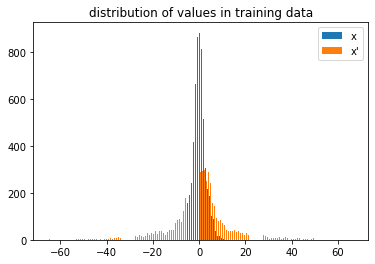

In [435]:
print(x_train.min(), x_train.max())
print(xt_train.min(), xt_train.max())
plt.hist([x_train.numpy().reshape(-1), xt_train.numpy().reshape(-1)], label=["x", "x'"], bins=150)
plt.title('distribution of values in training data')
plt.legend()
plt.show()

In [436]:
print(torch.all(x_train[:, 2:] == xt_train[:, :2]))

tensor(True)


# **Lagrangian Neural Network**

In [437]:
import torch.nn.functional as F

class LNN(nn.Module):
    def __init__(self):
        super(LNN, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        self.fc2 = nn.Linear(128, 128)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        self.fc3 = nn.Linear(128, 1)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
    
    def lagrangian(self, x): 
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        x = self.fc3(x)
        return x 

    def forward(self, x):
        eompar = partial(equation_of_motion, self.lagrangian, 0)
        return map_batch(eompar, x)
    

In [418]:
epochs = 10000
batch_size = 100
patience = 1000

In [438]:
train_losses = []
val_losses = []

if os.path.exists('tblog'):
    shutil.rmtree('tblog')
writer = tf.summary.create_file_writer('tblog', flush_millis=1000)

model = LNN()
opt = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = StepLR(opt, epochs // 100, 0.9)
criterion = nn.MSELoss()
waiting = 0
best_loss = float('inf')
for epoch in range(epochs):
    opt.zero_grad()
    xt_pred = model(x_train)
    loss = criterion(xt_pred, xt_train)
    loss.backward()
    opt.step()
    # for i in range(1, N // batch_size):
    #     xi = x_train[(i - 1) * batch_size:i * batch_size]
    #     opt.zero_grad()
    #     xt_pred = model(xi)
    #     loss = criterion(xt_pred, xt_train[(i - 1) * batch_size:i * batch_size])
    #     loss.backward()
    #     opt.step()
    print(f'[epoch: {epoch}, waiting: {waiting}]')
    print(f'train_loss: {loss.item():.2f}')
    train_losses.append(loss.item())

    xt_test_pred = model(x_test)
    val_loss = criterion(xt_test_pred, xt_test).item()
    val_losses.append(val_loss)
    print(f'val_loss: {val_loss:.4f}')

    with writer.as_default():
            tf.summary.scalar('train loss', loss.item(), step=epoch)
            tf.summary.scalar('val loss', val_loss, step=epoch)
            tf.summary.histogram('training distribution', xt_pred.detach(), step=epoch)
            tf.summary.histogram('val distribution', xt_test_pred.detach(), step=epoch)

    if val_loss < best_loss:
        best_loss = val_loss
        print(f'best validation loss achieved at epoch {epoch}: {best_loss:.4f}')
        waiting = 0
    else:
        waiting += 1
    if waiting > patience:
        break
    
    scheduler.step()

[epoch: 0, waiting: 0]
train_loss: 1912441.50
val_loss: 701.0117
best validation loss achieved at epoch 0: 701.0117
[epoch: 1, waiting: 0]
train_loss: 686.80
val_loss: 281.9721
best validation loss achieved at epoch 1: 281.9721
[epoch: 2, waiting: 0]
train_loss: 276.13
val_loss: 229.0564
best validation loss achieved at epoch 2: 229.0564
[epoch: 3, waiting: 0]
train_loss: 224.20
val_loss: 208.9013
best validation loss achieved at epoch 3: 208.9013
[epoch: 4, waiting: 0]
train_loss: 204.55
val_loss: 198.4146
best validation loss achieved at epoch 4: 198.4146
[epoch: 5, waiting: 0]
train_loss: 194.39
val_loss: 192.0393
best validation loss achieved at epoch 5: 192.0393
[epoch: 6, waiting: 0]
train_loss: 188.24
val_loss: 187.7817
best validation loss achieved at epoch 6: 187.7817
[epoch: 7, waiting: 0]
train_loss: 184.15
val_loss: 184.7536
best validation loss achieved at epoch 7: 184.7536
[epoch: 8, waiting: 0]
train_loss: 181.26
val_loss: 182.5008
best validation loss achieved at epoch 

KeyboardInterrupt: 

In [376]:
for n, p in model.named_parameters():
    print(n, p.mean().item(), p.std().item(), p.min().item(), p.max().item())

fc1.weight -0.0027104546315968037 0.1253814697265625 -0.33321014046669006 0.31112560629844666
fc1.bias -6.981333717703819e-05 0.0011238052975386381 -0.003418068401515484 0.003166238311678171
fc2.weight -0.0004265295574441552 0.08835474401712418 -0.32407572865486145 0.3468055725097656
fc2.bias 4.898403858533129e-05 0.0014785346575081348 -0.0025966009125113487 0.0031067009549587965
fc3.weight -0.011524302884936333 0.12495908886194229 -0.3562747538089752 0.2815256714820862
fc3.bias 0.0 nan 0.0 0.0


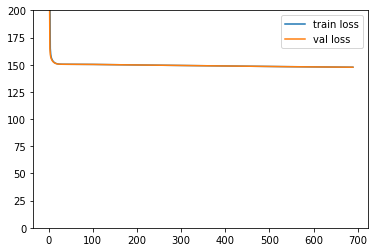

In [424]:
%matplotlib inline
plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')
plt.plot(np.arange(len(train_losses)), val_losses, label='val loss')
plt.legend()
plt.ylim(0, 200)
plt.show()

In [425]:
xt_pred = model(x_test)
xt_pred = xt_pred.detach().numpy()

Text(0, 0.5, '$\\ddot q_2$ predicted')

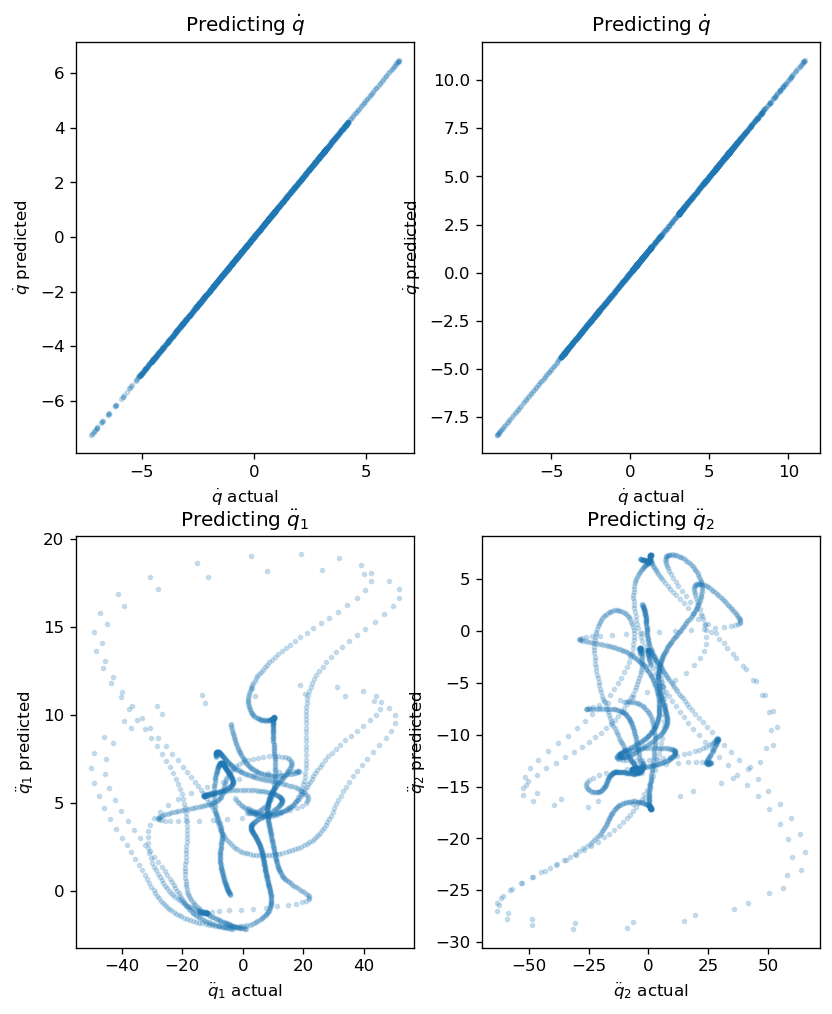

In [431]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), dpi=120)
axes[0][0].scatter(xt_test[:, 0], xt_pred[:, 0], s=6, alpha=0.2)
axes[0][0].set_title('Predicting $\dot q$')
axes[0][0].set_xlabel('$\dot q$ actual')
axes[0][0].set_ylabel('$\dot q$ predicted')
axes[0][1].scatter(xt_test[:, 1], xt_pred[:, 1], s=6, alpha=0.2)
axes[0][1].set_title('Predicting $\dot q$')
axes[0][1].set_xlabel('$\dot q$ actual')
axes[0][1].set_ylabel('$\dot q$ predicted')
axes[1][0].scatter(xt_test[:, 2], xt_pred[:, 2], s=6, alpha=0.2)
axes[1][0].set_title('Predicting $\ddot q_1$')
axes[1][0].set_xlabel('$\ddot q_1$ actual')
axes[1][0].set_ylabel('$\ddot q_1$ predicted')
axes[1][1].scatter(xt_test[:, 3], xt_pred[:, 3], s=6, alpha=0.2)
axes[1][1].set_title('Predicting $\ddot q_2$')
axes[1][1].set_xlabel('$\ddot q_2$ actual')
axes[1][1].set_ylabel('$\ddot q_2$ predicted')

In [168]:
from torchlagrangian.data.dataset import DoublePendulum

In [163]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)